In [1]:
import os
import cv2
import random
import pytorch_lightning as pl
import torch.nn as nn
import torchvision.models as models
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.data import Dataset, DataLoader
from torch.functional import F
from torchvision import transforms
from pytorch_lightning import loggers as pl_loggers

from torchinfo import summary

### Load Tensorboard extension

In [2]:
%load_ext tensorboard

### Load data

In [3]:
dir_original_ela = "./data/CASIA2/Au-ela/"
dir_tampered_ela = "./data/CASIA2/Tp-ela/"

images_original_ela = sorted(glob.glob(os.path.join(dir_original_ela, "*")))
images_tampered_ela = sorted(glob.glob(os.path.join(dir_tampered_ela, "*")))

### Dataset class

In [4]:
class ForgeryDetectionDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=None):
        super().__init__()

        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path)
        image = cv2.resize(image, dsize=(128, 128))

        label = image_path.split("/")[3]
        label = self.class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

### Create Neuronal Network based on resnet 18

In [5]:
class ForgeryDetectionNetwork(pl.LightningModule):
    def __init__(self, number_of_classes):
        super().__init__()

        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=number_of_classes)
        
        self.model = model
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.model(x)
                
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output, dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output,dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/train", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/train", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/valid", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/valid", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [6]:
summary(ForgeryDetectionNetwork(2), input_size=(4, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ForgeryDetectionNetwork                  --                        --
├─VGG: 1-1                               [4, 2]                    --
│    └─Sequential: 2-1                   [4, 512, 4, 4]            --
│    │    └─Conv2d: 3-1                  [4, 64, 128, 128]         1,792
│    │    └─ReLU: 3-2                    [4, 64, 128, 128]         --
│    │    └─Conv2d: 3-3                  [4, 64, 128, 128]         36,928
│    │    └─ReLU: 3-4                    [4, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-5               [4, 64, 64, 64]           --
│    │    └─Conv2d: 3-6                  [4, 128, 64, 64]          73,856
│    │    └─ReLU: 3-7                    [4, 128, 64, 64]          --
│    │    └─Conv2d: 3-8                  [4, 128, 64, 64]          147,584
│    │    └─ReLU: 3-9                    [4, 128, 64, 64]          --
│    │    └─MaxPool2d: 3-10              [4, 128, 32, 32]          --

### Create dataset and dataloader

In [7]:
class_to_idx = {"Au-ela": 0, "Tp-ela": 1}
idx_to_class = {0: "Au-ela", 1: "Tp-ela"}

In [8]:
random.seed(42)

test_image_original_paths = random.sample(images_original_ela, 10)
test_image_tampered_paths = random.sample(images_tampered_ela, 10)
test_image_paths = test_image_original_paths + test_image_tampered_paths

train_valid_images_original_ela = [o for o in images_original_ela if o not in test_image_original_paths]
train_valid_images_tampered_ela = [t for t in images_tampered_ela if t not in test_image_tampered_paths]

train_valid_images_paths = images_original_ela[:3000] + images_tampered_ela
random.shuffle(train_valid_images_paths)

train_image_paths, valid_image_paths = train_test_split(train_valid_images_paths, train_size=0.7)

print("Length train and validation dataset:", len(train_valid_images_paths))
print("Length train dataset", len(train_image_paths))
print("Length validation dataset", len(valid_image_paths))
print("Length test dataset", len(test_image_paths))

Length train and validation dataset: 5064
Length train dataset 3544
Length validation dataset 1520
Length test dataset 20


In [9]:
image_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip()
])

In [10]:
train_dataset = ForgeryDetectionDataset(train_image_paths, class_to_idx=class_to_idx, transform=image_transformations)
valid_dataset = ForgeryDetectionDataset(valid_image_paths, class_to_idx=class_to_idx, transform=image_transformations)
test_dataset = ForgeryDetectionDataset(test_image_paths, class_to_idx=class_to_idx, transform=image_transformations)

In [11]:
def create_dataloaders(batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=0)
    test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=0)

    print(f"Train dataloader shape {next(iter(train_dataloader))[0].shape}")
    print(f"Validation dataloader shape {next(iter(validation_dataloader))[0].shape}")
    print(f"Test dataloader shape {next(iter(test_dataloader))[0].shape}")

    return train_dataloader, validation_dataloader, test_dataloader

In [12]:
test_train_dataloader, _, _ = create_dataloaders(1)

Train dataloader shape torch.Size([1, 3, 128, 128])
Validation dataloader shape torch.Size([1, 3, 128, 128])
Test dataloader shape torch.Size([1, 3, 128, 128])


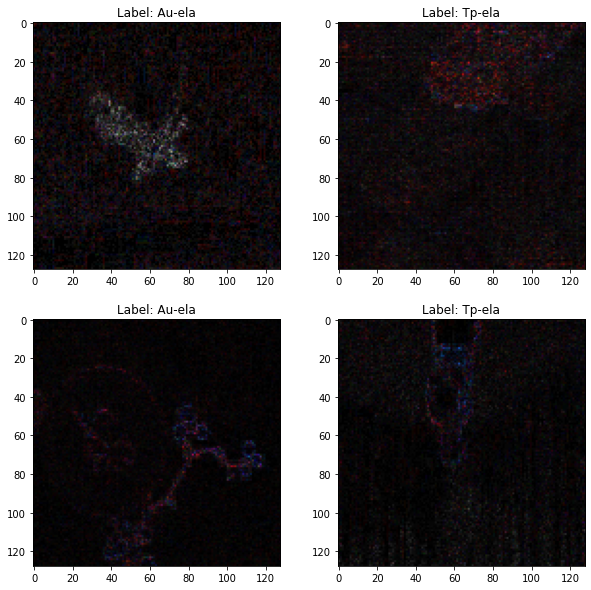

In [13]:
fig = plt.figure(figsize=(10, 10))
train_dataloader_iter = iter(test_train_dataloader)

for i in range(4):
    batch, label = next(train_dataloader_iter)

    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_title(f"Label: {idx_to_class[label.item()]}")
    ax.imshow(batch[0].numpy().transpose(1, 2, 0))

plt.show()

### Create Model

In [14]:
forgery_detection_model = ForgeryDetectionNetwork(number_of_classes=len(class_to_idx))

In [15]:
train_dataloader, validation_dataloader, test_dataloader = create_dataloaders(100)

Train dataloader shape torch.Size([100, 3, 128, 128])
Validation dataloader shape torch.Size([100, 3, 128, 128])
Test dataloader shape torch.Size([1, 3, 128, 128])


In [16]:
logger = pl_loggers.TensorBoardLogger("logs/", name="VGG-Model")

In [17]:
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=1, logger=logger)
trainer.fit(forgery_detection_model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | VGG              | 134 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.075   Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 52/52 [27:12<00:00, 31.39s/it, loss=0.312, v_num=1, Loss/valid=0.289, Accuracy/valid=0.895, Loss/train=0.307, Accuracy/train=0.884]


In [19]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6009 (pid 92218), started 0:00:05 ago. (Use '!kill 92218' to kill it.)

In [20]:
validation_model = ForgeryDetectionNetwork(number_of_classes=len(idx_to_class))
checkpoint_gaf = torch.load("logs/VGG-Model/version_1/checkpoints/epoch=9-step=359.ckpt")

validation_model.load_state_dict(checkpoint_gaf["state_dict"])
validation_model.eval()

ForgeryDetectionNetwork(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tr

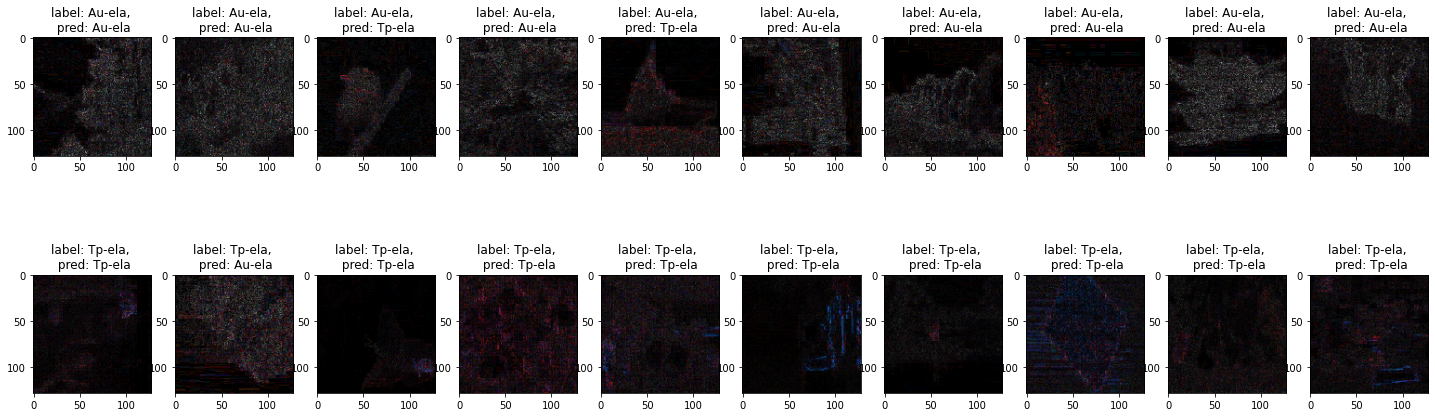

In [21]:
fig = plt.figure(figsize=(25, 8))
spec = fig.add_gridspec(ncols=10, nrows=2)

test_iter = iter(test_dataloader)

y_pred = list()
y_true = list()

count = 0
for row in range(2):
    for col in range(10):
        batch, label = next(test_iter)
        
        pred = validation_model(batch)
        pred = pred.argmax(dim=1)

        ax = fig.add_subplot(spec[row, col])

        ax.imshow(batch[0].numpy().transpose(1, 2, 0))
        ax.set_title(f'label: {idx_to_class[label.item()]}, \n pred: {idx_to_class[pred.item()]}')

        y_pred.append(idx_to_class[pred.item()])
        y_true.append(idx_to_class[label.item()])

        count += 1

In [22]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Au-ela       0.89      0.80      0.84        10
      Tp-ela       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



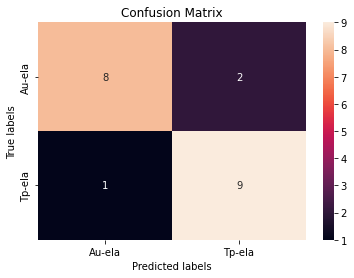

In [23]:
con_matrix = confusion_matrix(y_true, y_pred)

ax = plt.subplot()
sns.heatmap(con_matrix, annot=True, fmt="d")
ax.set_title('Confusion Matrix')
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.xaxis.set_ticklabels(["Au-ela", "Tp-ela"])
ax.yaxis.set_ticklabels(["Au-ela", "Tp-ela"])

plt.show()